In [1]:
import torch
import torch.optim as optim

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchinfo import summary

from src.datasets import IrmaDataset
from src.transforms import MinMaxScaler, Sobel, Laplacian, GammaCorrection, HistogramEqualizer
from src.models import VAE, PVAE, PAE
from src.utils.model_utils import train_val_split, get_latent, predict
from src.utils.visualization import (
    plot_reconstructions,
    plot_2d,
    sample_images,
    plot_history,
)
from src.utils.training_funcs import (
    train,
    validate,
    pred_loss,
    pred_reconstruction_loss,
    pred_kl_reconstruction_loss,
    kl_reconstruction_loss,
    get_metrics_str,
    pred_loss,
)

In [2]:
torch.backends.cudnn.benchmark = True
batch_size = 32

In [3]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            # MinMaxScaler(),
            HistogramEqualizer(),
            Sobel(),
            # HistogramEqualizer()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=12)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=12)}
# train_datasets = train_val_split(datasets['train'], 1 / 4, random_state=12)
# datasets['train'] = train_datasets['train']

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']),  len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

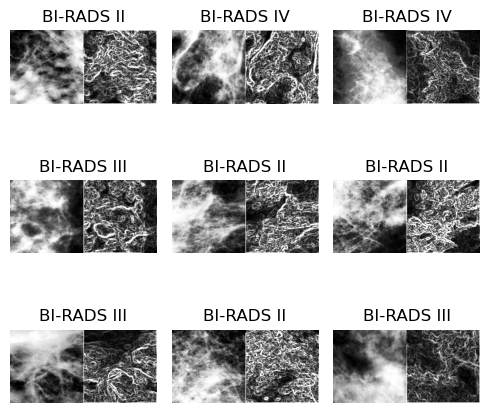

In [4]:
sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label, plot_borders=True)

### PVAE - 128

In [5]:
pae = PAE(
    latent_dim=128,
    n_channels=2,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 84)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(84, 6, 6),
    linear_layers=[512, 256, 128],
    pred_layers=[256, 128, 64],
    use_batchnorm=True,
    n_classes=4,
    clamp_output=False
)
summary(pae, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PAE                                      [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 84, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pae.parameters())
pae.to(device)

hist = train(pae, optimizer, dataloaders['train'], dataloaders['val'], 24, pred_reconstruction_loss)

[epoch: 1] train_loss: 15.7147 - train_rec_loss: 14.4349 - train_pred_loss: 1.2798 - train_accuracy: 0.4161 - val_loss: 9.2674 - val_rec_loss: 8.0258 - val_pred_loss: 1.2416 - val_accuracy: 0.4533
[epoch: 2] train_loss: 8.5359 - train_rec_loss: 7.3292 - train_pred_loss: 1.2067 - train_accuracy: 0.5037 - val_loss: 8.4948 - val_rec_loss: 7.2958 - val_pred_loss: 1.1990 - val_accuracy: 0.5368
[epoch: 3] train_loss: 8.0563 - train_rec_loss: 6.8939 - train_pred_loss: 1.1624 - train_accuracy: 0.5694 - val_loss: 8.1503 - val_rec_loss: 6.9735 - val_pred_loss: 1.1768 - val_accuracy: 0.5626
[epoch: 4] train_loss: 7.7369 - train_rec_loss: 6.5869 - train_pred_loss: 1.1500 - train_accuracy: 0.5831 - val_loss: 7.8886 - val_rec_loss: 6.7251 - val_pred_loss: 1.1635 - val_accuracy: 0.5686
[epoch: 5] train_loss: 7.4509 - train_rec_loss: 6.3109 - train_pred_loss: 1.1400 - train_accuracy: 0.5933 - val_loss: 7.7394 - val_rec_loss: 6.5580 - val_pred_loss: 1.1813 - val_accuracy: 0.5467
[epoch: 6] train_loss: 

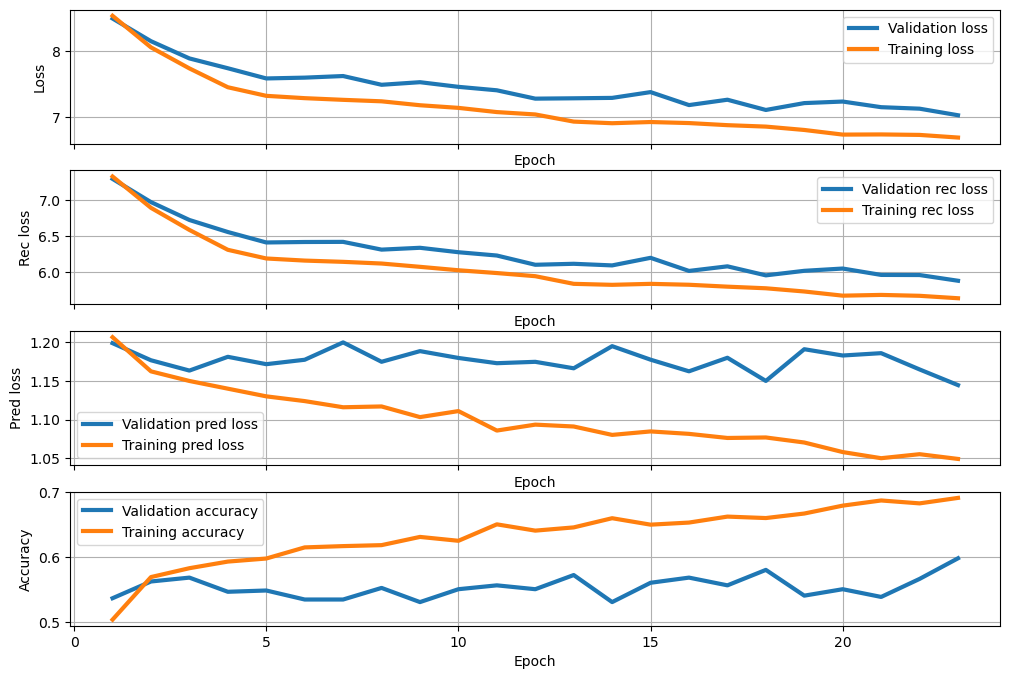

In [7]:
plot_history(hist[1:])

test_loss: 7.1343 - test_rec_loss: 6.0255 - test_pred_loss: 1.1088 - test_accuracy: 0.6282


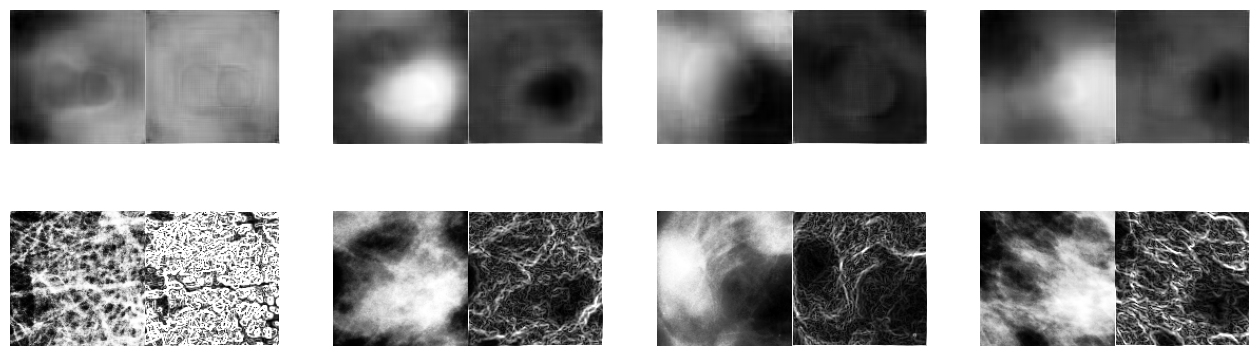

In [8]:
test_metrics = validate(pae, dataloaders['test'], pred_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pae, dataloaders['test'], plot_borders=True)

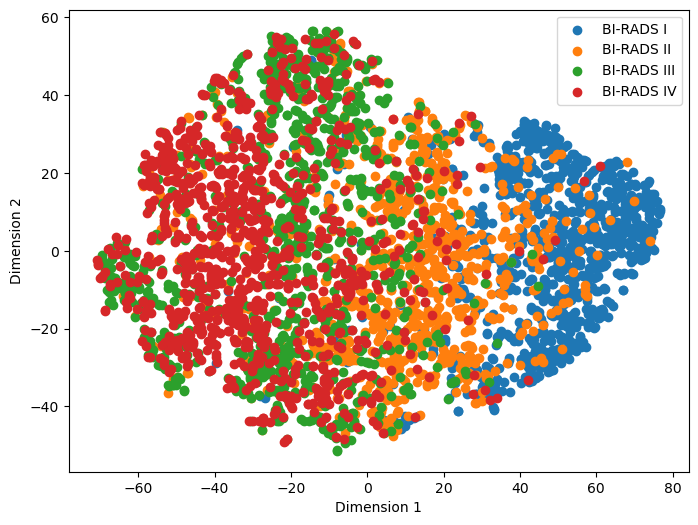

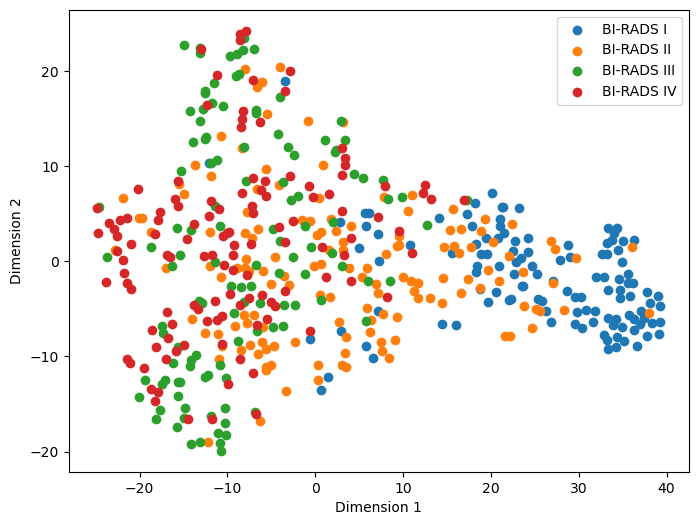

In [13]:
train_latent, train_labels = get_latent(pae, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pae, dataloaders["val"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [14]:
train_latent, train_labels = get_latent(pae, dataloaders["train"])
val_latent, val_labels = get_latent(pae, dataloaders["val"])
latent, labels = get_latent(pae, dataloaders["test"])

In [15]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [16]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [17]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(128, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 16,512
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 90,948
Trainable params: 90,948
Non-trainable params: 0
Total mult-adds (M): 2.91
Input size (MB): 0.02
Forward/backward pass

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00001)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 96, pred_loss)

[epoch: 1] train_loss: 1.3845 - train_predict_loss: 1.3845 - train_accuracy: 0.2501 - val_loss: 1.3826 - val_predict_loss: 1.3826 - val_accuracy: 0.2346
[epoch: 2] train_loss: 1.3772 - train_predict_loss: 1.3772 - train_accuracy: 0.2501 - val_loss: 1.3720 - val_predict_loss: 1.3720 - val_accuracy: 0.2346
[epoch: 3] train_loss: 1.3527 - train_predict_loss: 1.3527 - train_accuracy: 0.2514 - val_loss: 1.3361 - val_predict_loss: 1.3361 - val_accuracy: 0.2445
[epoch: 4] train_loss: 1.3029 - train_predict_loss: 1.3029 - train_accuracy: 0.3024 - val_loss: 1.3034 - val_predict_loss: 1.3034 - val_accuracy: 0.3320
[epoch: 5] train_loss: 1.2717 - train_predict_loss: 1.2717 - train_accuracy: 0.4291 - val_loss: 1.2841 - val_predict_loss: 1.2841 - val_accuracy: 0.4553
[epoch: 6] train_loss: 1.2490 - train_predict_loss: 1.2490 - train_accuracy: 0.5097 - val_loss: 1.2642 - val_predict_loss: 1.2642 - val_accuracy: 0.4811
[epoch: 7] train_loss: 1.2279 - train_predict_loss: 1.2279 - train_accuracy: 0.501

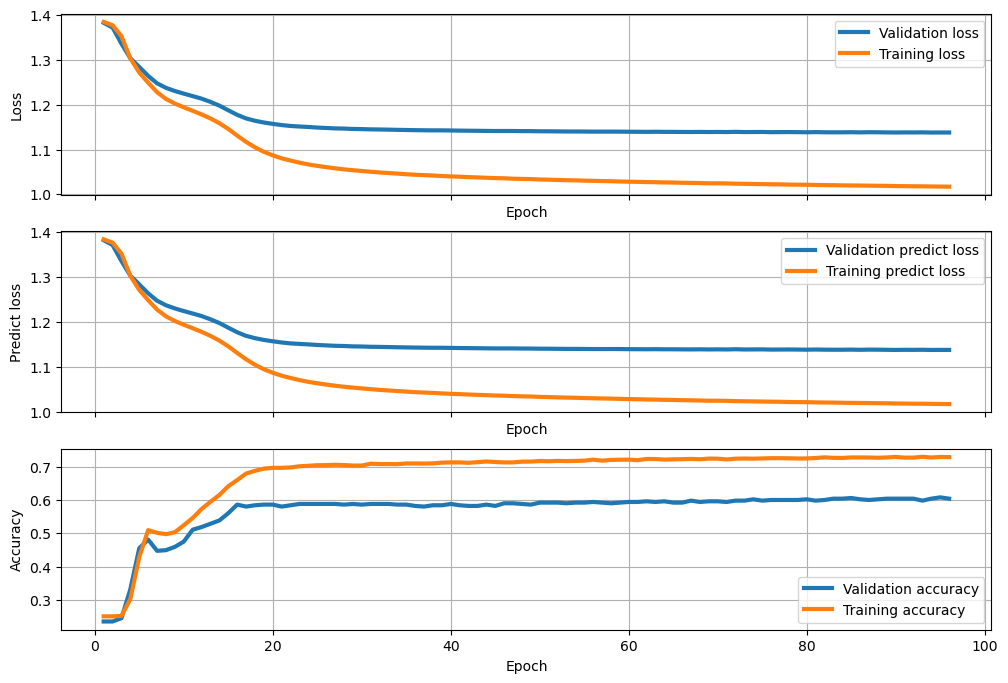

In [19]:
plot_history(hist)

In [20]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.1198 - test_predict_loss: 1.1198 - test_accuracy: 0.6143


In [21]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       133
           1       0.54      0.57      0.55       118
           2       0.53      0.50      0.51       121
           3       0.54      0.56      0.55       131

    accuracy                           0.61       503
   macro avg       0.61      0.61      0.61       503
weighted avg       0.62      0.61      0.62       503



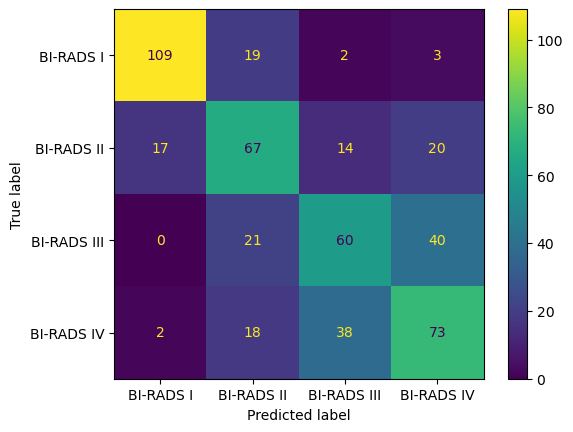

In [22]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()